In [1]:
import numpy as np
import pyemma
import msmtools.estimation as est
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pyemma.plots as mplt
import h5py
import MSMRD.trajectories.trajectoryTools as trajectoryTools
from MSMRD.discretization import partitionSphere, plotPartitionedSphere
from MSMRD.visualization import createDensityData
%load_ext Cython

/home/maojrs/miniconda2/lib/python2.7/site-packages/pyemma/__init__.py:91: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.4, you have 2.3.2.
  .format(latest=latest, current=current), category=UserWarning)


In [2]:
%matplotlib inline
#%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (4.0, 4.0)
plt.rc('text', usetex='True')
plt.rc('font', family='serif')

234


/home/maojrs/miniconda2/lib/python2.7/site-packages/MSMRD-0.1-py2.7-linux-x86_64.egg/MSMRD/discretization/spherePartition.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


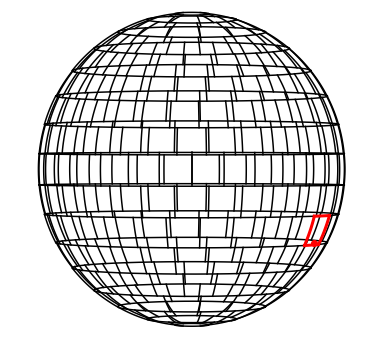

In [3]:
# Testing correct state output mini script (use along with testSpherePrtitionPlot NB)
# Consistent with test
numPartitions = 322
boxSize = 6
innerMSMrad = 2.5
minima = np.array([[-0.9,0.7,0.3] , [-0.1,0.9,0.7],  [0.8,0.8,-0.8],  \
                  [-1.0,-0.3,-0.4], [0.0,0.0,0.0],   [0.9,-0.1,-0.9], \
                  [-0.7,-1.0,-0.3], [0.0,-0.9,0.1],  [0.8,-0.2,0.8]])
regionsPerCollar, phis, thetas = partitionSphere(numPartitions)
discretizer = trajectoryTools.trajDiscretization3DCython(minima, boxSize, innerMSMrad)
discretizer.getSpherePartition(regionsPerCollar, phis, thetas)
coord = np.array([3.4,-2,-2]) # norm larger than innerMSMrad (boxSize/2)
sphereState = discretizer.getStatePy(coord,-1) - (len(minima) - 1)

# Call function to plot state and coordinate in spherical partition
print sphereState
plotPartitionedSphere(numPartitions = numPartitions, plotState=sphereState, coord=coord)

In [4]:
%%time
numfiles = 100
# Load partitions, boxsize and minimas
numPartitions = 100
boxSize = 6
innerMSMrad = 2.5
regionsPerCollar, phis, thetas = partitionSphere(numPartitions)
minima = np.array([[-0.9,0.7,0.3] , [-0.1,0.9,0.7],  [0.8,0.8,-0.8],  \
                  [-1.0,-0.3,-0.4], [0.0,0.0,0.0],   [0.9,-0.1,-0.9], \
                  [-0.7,-1.0,-0.3], [0.0,-0.9,0.1],  [0.8,-0.2,0.8]])

# Extract trajectories from file using asym2Dtraj class
# fname = '../data/asym3D/3DasymTrajs_pBox5_sf2_R4_RT1e7_dt001_si10_' # old data with bug in potential
# fname = '../data/asym3D/3DasymTrajs_pbox5_RT1e7_sf2.0_dt0.001_si10_run_'
fname = '../data/asym3D/3DasymTrajs_pbox6_RT1e7_sf2.0_dt0.001_si10_run_'
dimension = 3
discretizer = trajectoryTools.trajDiscretization3DCython(minima, boxSize,innerMSMrad)
discretizer.getSpherePartition(regionsPerCollar, phis, thetas)
trajs = []
dTrajs = []
#fullDTrajs = []
truncTrajs = []
dTruncTrajs = []
i = 0
samplingInterval = 10 # in the original computation
for number in range(numfiles):
    f = h5py.File(fname + str(number) + '.h5', 'r')
    data = np.array(f['traj'], dtype=float)
    f.close()
    if not np.allclose(data[1:,0]-data[:-1,0], samplingInterval):
        print 'timestep not constant'
    traj = data[:,1:dimension+1]
    #fullDTrajs.append(discretizer.getdTrajs([traj]))
    dTrajs += discretizer.getdTrajs([traj])
    lastTruncTrajs = discretizer.getTruncatedTraj(traj, prepend=True) # Use True for code, false for traj plotting?
    truncTrajs += lastTruncTrajs
    dTruncTrajs += discretizer.getdTrajs(lastTruncTrajs)
    i+=1
    if i % 10 == 0:
        print str(i/float(numfiles) * 100)+'% done'
    # delete memory to avoid overhead
    del data
    del traj
    #trajs.append(traj) # Need to pass to create density data for visit visualization

10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done
CPU times: user 33min 47s, sys: 2.63 s, total: 33min 50s
Wall time: 33min 50s


In [ ]:
# visualize trunc trajs
def plotTrajs(trajs,numTrajs):
    fig = plt.figure(figsize=[10,10])
    ax = fig.gca(projection='3d') 
    i=0
    print(len(trajs))
    for traj in trajs:
        trajx = []
        trajy = []
        trajz = []
        for i in range(len(traj)):
            trajx.append(traj[i][0])
            trajy.append(traj[i][1])
            trajz.append(traj[i][2])
        #ax.plot(trajx,trajy,trajz,'.')
        ax.plot(trajx,trajy,trajz,'b-', lw=0.0002)
        i += 1
        if i > numTrajs:
            break
            
plotTrajs(truncTrajs,100000)

In [5]:
# Get exit/entry lookup tables
%time
# CALL WITH dTruncTrajs or dTrajs, see function in trajectoryTools.pyx
entryTrajsStart, entryTrajsEnd, entryTimes = discretizer.getLookupTableEntry(dTruncTrajs, truncTrajs)
exitPositions, exitTimes = discretizer.getLookupTableExit(dTruncTrajs, truncTrajs)
transitionTrajs = discretizer.getTransitionTrajs(dTruncTrajs)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs


In [6]:
for i in range(len(dTruncTrajs)):
    if np.any(dTruncTrajs[i] < 0):
        print 'found one'
        break

In [ ]:
hist = plt.hist(entryTimes, bins=100)

In [ ]:
state = 8
plt.scatter(np.array(exitPositions[state])[:,0], np.array(exitPositions[state])[:,1], 0.1)

In [9]:
%time
exitTrajs = []
for i in range(9):
    exitTrajs += (transitionTrajs[i][9])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


In [10]:
# Calculate transition and exit probabilities for each of the inner states
exitProbs = np.zeros(len(minima))
transitionProbs = np.zeros((len(minima),len(minima)))
for i in range(len(minima)):
    # Calculate exit probs
    outgoingTrajs = 0
    for j in range(len(minima)+1):
        outgoingTrajs += len(transitionTrajs[i][j])   
    exitProbs[i] = len(transitionTrajs[i][len(minima)])/float(outgoingTrajs)
    # Calculate transition probs
    for k in range(len(minima)):
        transitionProbs[i][k] = len(transitionTrajs[i][k])/float(outgoingTrajs)
print exitProbs

[ 0.31655326  0.2886561   0.42777817  0.17133827  0.1066546   0.37623448
  0.16470774  0.16397181  0.43449801]


In [14]:
np.cumsum(transitionProbs[2]/sum(transitionProbs[2]))

array([ 0.05153405,  0.1085601 ,  0.1085601 ,  0.14196639,  0.26592889,
        0.91084775,  0.92653921,  0.95263658,  1.        ])

In [15]:
# Prob consistency test (must print all ones)
for k in range(len(minima)):
    totalProb = 0
    for i in range(len(minima)):
        totalProb += transitionProbs[k][i]
    print totalProb + exitProbs[k]

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [16]:
# Partition MSM entry trajectories into discrete regions in the sphere 
spherePartitionsForLookUp = 1*numPartitions
regionsPerCollar2, phis2, thetas2 = partitionSphere(spherePartitionsForLookUp)
thetas_coord = np.arctan2(entryTrajsStart[:,1], entryTrajsStart[:,0])
thetas_coord[thetas_coord<0] = thetas_coord[thetas_coord<0] + 2*np.pi
r = np.linalg.norm(entryTrajsStart[:], axis=1)
phis_coords = np.arccos(entryTrajsStart[:,2]/r)
sortedEntryTrajsStart = []
sortedEntryTrajsEnd = []
sortedEntryTimes = []
for i in range(len(regionsPerCollar2)):
    phiIncrement = np.pi/len(regionsPerCollar2)
    idcs_phi = np.where(np.logical_and(phis_coords>i*phiIncrement, phis_coords<= (i+1)*phiIncrement))[0]
    for j in range(regionsPerCollar2[i]):
        thetaIncrement = 2*np.pi/regionsPerCollar2[i]
        idcs_theta = np.where(np.logical_and(thetas_coord>j*thetaIncrement, thetas_coord<= (j+1)*thetaIncrement))[0]
        idcs = np.intersect1d(idcs_phi,idcs_theta)
        sortedEntryTrajsStart.append(entryTrajsStart[idcs])
        sortedEntryTimes.append(entryTimes[idcs])
        sortedEnds = []
        for j in idcs:
            sortedEnds.append(entryTrajsEnd[j])
        sortedEntryTrajsEnd.append(sortedEnds)
        

In [17]:
#Prepare data to be extracted to file
#For this we need the position of the cluster centers as well as the information about the angles of the exit states
class truncTrajsModel3D(object):    
    def __init__(self, entryTrajsStart, entryTrajsEnd, entryTimes, exitTrajs, exitTimes, exitProbs, transitionProbs, transitionTrajs, numPartitions):
        self.entryTrajsStart = entryTrajsStart
        self.entryTrajsEnd = entryTrajsEnd
        self.entryTimes = entryTimes
        self.exitTrajs = exitTrajs
        self.exitTimes = exitTimes
        self.exitProbs = exitProbs
        self.transitionProbs = transitionProbs
        self.transitionTrajs = transitionTrajs
        self.numPartitions = numPartitions

In [18]:
model = truncTrajsModel3D(sortedEntryTrajsStart, sortedEntryTrajsEnd, sortedEntryTimes, exitPositions, exitTimes, exitProbs, transitionProbs, transitionTrajs, numPartitions)

In [19]:
import pickle
pickle.dump(model, open('../data/models/asym3D/periodicModel_trajstats_lag20_1file_322partitions.p', 'wa'))